In [21]:
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt

from desilike.samples import plotting, Chain
from getdist import plots
import getdist.plots as gdplt
from getdist import MCSamples

In [22]:
import matplotlib as mpl
fontsize = 14
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 1.5
#rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize' % axis] = fontsize-2
    rcparams['%stick.direction' % axis] = 'in'
    rcparams['%stick.major.size' % axis] = 5.5
    rcparams['%stick.minor.size' % axis] =  3.5
    rcparams['%stick.major.width' % axis] = 2
    rcparams['%stick.minor.width' % axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
# set up the plotting params
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [23]:
# setup the outdir - where plots will be saved
outdir = '/pscratch/sd/u/uendert/real_data_results/test_y1_full_shape/double_blinded/figs/'
os.makedirs(outdir, exist_ok=True)

In [24]:
def get_blind_cosmo(type, zmin, zmax, w0_blind=-0.90, wa_blind=0.26, fiducial_f=0.8):
    # NB: Blinded parameters values used for the double-blinded analysis: w0_blind=-0.90, wa_blind=0.26, and fnl=20.
    # Constants
    tp2z = {'LRG': 0.8, 'ELG': 1.1, 'QSO': 1.6,'BGS': 0.25}
    tp2bias = {'LRG': 2., 'ELG': 1.3, 'QSO': 2.3,'BGS':1.8}
    
    # ztp = z
    ztp = tp2z[type[:3]]
    bias = tp2bias[type[:3]]

    # Compute f_blind     
    from cosmoprimo.fiducial import DESI
    cosmo_fid = DESI()
    cosmo_shift = cosmo_fid.clone(w0_fld=w0_blind, wa_fld=wa_blind)
    DM_fid = cosmo_fid.comoving_angular_distance(ztp)
    DH_fid = 1. / cosmo_fid.hubble_function(ztp)
    DM_shift = cosmo_shift.comoving_angular_distance(ztp)
    DH_shift = 1. / cosmo_shift.hubble_function(ztp)
    vol_fac =  (DM_shift**2 * DH_shift) / (DM_fid**2 * DH_fid)
    a = 0.2 / bias**2
    b = 2 / (3 * bias)
    c = 1 - (1 + 0.2 * (fiducial_f / bias)**2. + 2/3 * fiducial_f / bias) / vol_fac
    f_blind = (-b + np.sqrt(b**2. - 4.*a*c))/(2*a)
    dfper = (f_blind - fiducial_f)/fiducial_f
    maxfper = 0.1
    if abs(dfper) > maxfper:
        dfper = maxfper*dfper/abs(dfper)
        f_blind = (1+dfper)*fiducial_f
    
    from cosmoprimo.fiducial import DESI
    cosmo = fiducial = DESI()

    ztp = (zmax+zmin)/2.
    print("=====================================")
    print(f"ztp: {ztp}")
    cosmo = fiducial.clone(w0_fld=w0_blind, wa_fld=wa_blind)
    qpar = cosmo.efunc(ztp) / fiducial.efunc(ztp)
    qper = fiducial.comoving_angular_distance(ztp) / cosmo.comoving_angular_distance(ztp)
    qiso = (qpar * qper**2)**(1/3)
    qap = qpar / qper
    df = f_blind / fiducial_f

    return dict(qpar=qpar, qper=qper, df=df, dm=0., qiso=qiso, qap=qap)


In [25]:
shift = get_blind_cosmo("LRG", 0.6, 1.0, w0_blind=-0.90, wa_blind=0.26, fiducial_f=0.8)
shift

ztp: 0.8


{'qpar': 1.0443199716351386,
 'qper': 1.02719533555478,
 'df': 1.1,
 'dm': 0.0,
 'qiso': 1.0328721171289854,
 'qap': 1.016671255687809}

In [26]:
# desilike
def process_chains(chain_dirs=os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'double_blinded'),
                   observable='corr', tracer=['LRG1'],
                   templates=['shapefit', 'shapefit-qisoqap', 'shapefit-qisoqap-prior']
                ):
    # set up zmin, zmax for this tracer
    zmin, zmax = {'LRG1': [0.4, 0.6], 'LRG2': [0.6, 0.8], 'LRG3': [0.8, 1.1],
                   'ELG1':[0.8, 1.1], 'ELG2': [1.1, 1.6],
                   'QSO1': [0.8, 2.1],
                   'BGS1': [0.1, 0.4]
                   
                   }[tracer]

    # modify the names to be what the files have
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso' + tracer[-1]
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.5' + tracer[-1]
    
    # expexted values due to the double blinding shift 
    # ref_values = get_cosmo_blind(tracer[:-1], zmin, zmax)
    # print(f"Expected shift: {ref_values}")
    
    # misc
    chain_dirs = np.array(chain_dirs)
    template = templates[0]
    templates_readin = []

    # load in the chains
    chains = []
    labels = []
    for chain_dir in chain_dirs:
        print(f'reading chains for {chain_dir} .. ')


        print(os.path.join(chain_dir, 'chain_{}_{}_{}_{}_velocileptors_{}_0.npy'.format(tracer[:-1], zmin, zmax, observable, template,)))
        if os.path.exists(os.path.join(chain_dir, 'chain_{}_{}_{}_{}_velocileptors_{}_0.npy'.format(tracer[:-1], zmin, zmax, observable, template,))):
            chain = Chain.concatenate([Chain.load(os.path.join(chain_dir,
                                                            'chain_{}_{}_{}_{}_velocileptors_{}_{:d}.npy'.format(tracer[:-1], zmin, zmax, observable, template,
                                                                                                                    i))).remove_burnin(0.5)[::20] for i in range(8)])
            chain = chain.sample_solved()
            chains.append(chain.to_getdist())
        
    # Assume this is your existing MCSamples object
    samples_original = chains[0]  # replace with your actual object

    # Get the list of parameter names
    param_names = samples_original.getParamNames().list()

    # Extract labels from the original samples
    labels = [name.label for name in samples_original.getParamNames().names]

    # Create a dictionary mapping parameter names to indices
    param_to_index = {name: idx for idx, name in enumerate(param_names)}

    # Define the shifts
    shifts = get_blind_cosmo(tracer[:-1], zmin=zmin, zmax=zmax)

    samples_array = samples_original.samples.copy()

    # Apply the shifts
    for param, shift_value in shifts.items():
        print(param, shift_value)
        if param in param_to_index:
            if shift_value != 0:
                samples_array[:, param_to_index[param]] *= shift_value
        else:
            print(f"Parameter {param} not found in the chains.")

    # Create a new MCSamples object for the shifted samples
    samples_shifted = MCSamples(samples=samples_array, names=param_names, 
                                labels=labels, 
                                settings={'boundary_correction_order': 0, 'mult_bias_correction_order': 1})
        
    chains.append(samples_shifted)

    #colors = ['#FF7F0E', '#1F77B4', '#2CA02C']
    colors = ['#FF7F0E', '#1F77B4', 'k']
    plt.clf()
    g = plots.get_subplot_plotter()
    g.settings.alpha_filled_add = 0.8
    g.settings.title_limit_fontsize = 20
    g.settings.axes_labelsize = 20
    g.settings.legend_fontsize = 20
    g.settings.line_labels = True
    g.triangle_plot(chains, params=["qiso", "qap", "df", "dm"], analysis_settings={'ignore_rows': 0.3},
                    filled=False, contour_lws=[2, 2, 1], contour_ls=['-', '-', '--'],
                    contour_colors=colors,
                    #markers={"qiso":1., "qap":1., "df":1., "dm":0.}, marker_args={'ls': '-'},
                    legend_labels=['Original', 'Target', 'Shifted']
                    )
    plt.tight_layout()
    plt.suptitle(f"{tracer[:-1]}: [{zmin},{zmax}]", fontweight="bold", y=1.05)
    fname = 'plot_posteriors_orignal_target_shift-qiso-qap-dm-df_{}_{}_{}_{}_velocileptors.png'.format(tracer[:-1], zmin, zmax, observable, len(templates_readin))
    plt.savefig(f'{outdir}/{fname}', format='png', bbox_inches='tight')
    print(f'saved {fname}')
    plt.show()
    return chains

############################################################
plotting things for LRG1
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/single_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded/chain_LRG_0.4_0.6_corr_velocileptors_shapefit-qisoqap_0.npy
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/chain_LRG_0.4_0.6_corr_velocileptors_shapefit-qisoqap_0.npy
Removed no burn in
ztp: 0.5
qpar 1.037416033742422
Parameter qpar not found in the chains.
qper 1.0205701459498924
Parameter qper not found in the chains.
df 1.1
dm 0.0
qiso 1.026154826109796
qap 1.016506349768688
Removed no burn in


/tmp/ipykernel_1890727/3720870479.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors_orignal_target_shift-qiso-qap-dm-df_LRG_0.4_0.6_corr_velocileptors.png


<Figure size 1000x600 with 0 Axes>

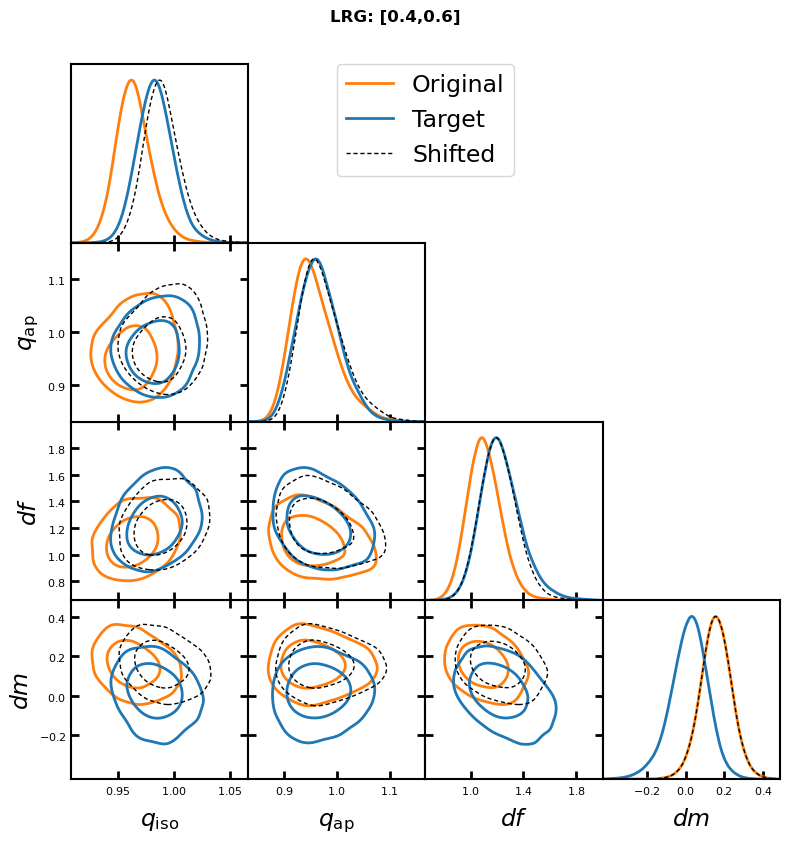

############################################################


############################################################
plotting things for LRG2
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/single_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded/chain_LRG_0.6_0.8_corr_velocileptors_shapefit-qisoqap_0.npy
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/chain_LRG_0.6_0.8_corr_velocileptors_shapefit-qisoqap_0.npy
Removed no burn in
ztp: 0.7
qpar 1.0429797166411068
Parameter qpar not found in the chains.
qper 1.0253829894145665
Parameter qper not found in the chains.
df 1.1
dm 0.0
qiso 1.0312153281422698
qap 1.0171611265334009
Removed no burn in


/tmp/ipykernel_1890727/3720870479.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors_orignal_target_shift-qiso-qap-dm-df_LRG_0.6_0.8_corr_velocileptors.png


<Figure size 1000x600 with 0 Axes>

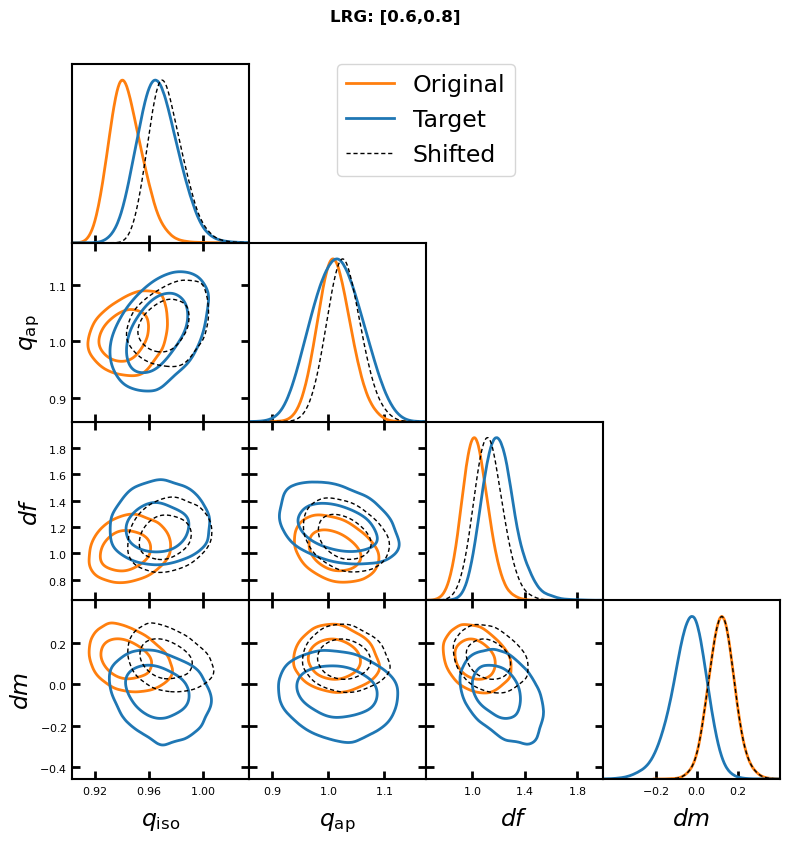

############################################################


############################################################
plotting things for LRG3
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/single_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/single_blinded/chain_LRG_0.8_1.1_corr_velocileptors_shapefit-qisoqap_0.npy
Removed no burn in
reading chains for /pscratch/sd/u/uendert/test_y1_full_shape/double_blinded .. 
/pscratch/sd/u/uendert/test_y1_full_shape/double_blinded/chain_LRG_0.8_1.1_corr_velocileptors_shapefit-qisoqap_0.npy
Removed no burn in
ztp: 0.9500000000000001
qpar 1.0450470492377948
Parameter qpar not found in the chains.
qper 1.0293206611811896
Parameter qper not found in the chains.
df 1.1
dm 0.0
qiso 1.0345363177141143
qap 1.0152784148319325
Removed no burn in


/tmp/ipykernel_1890727/3720870479.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


saved plot_posteriors_orignal_target_shift-qiso-qap-dm-df_LRG_0.8_1.1_corr_velocileptors.png


<Figure size 1000x600 with 0 Axes>

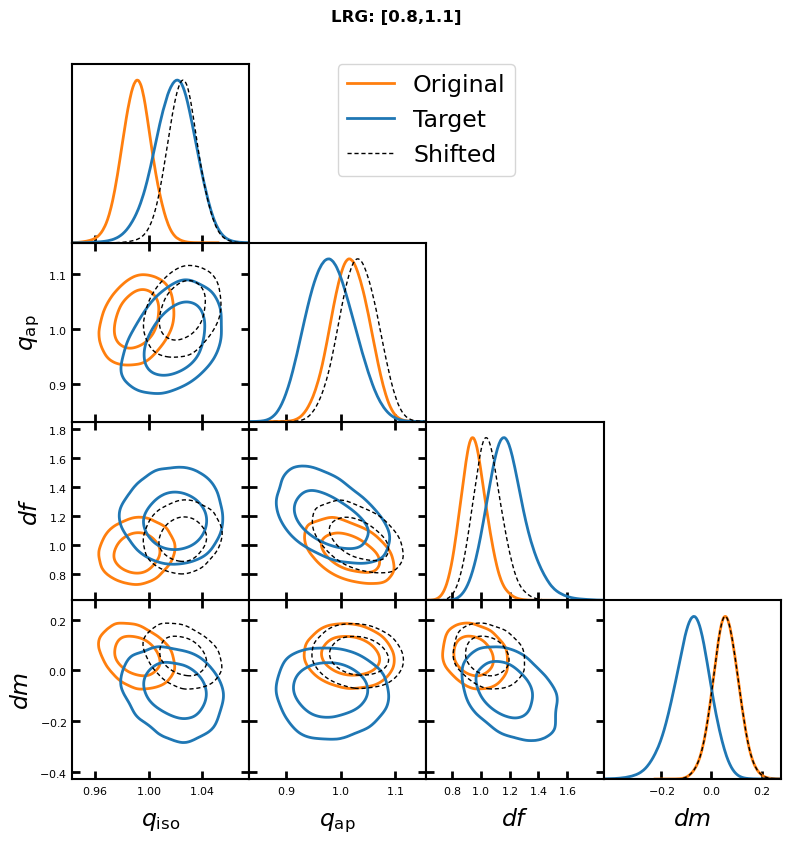

############################################################


CPU times: user 1min 55s, sys: 6min, total: 7min 55s
Wall time: 24.6 s


In [27]:
%%time

for tracer in ['LRG1','LRG2', 'LRG3']:
   print('############################################################')
   print(f'plotting things for {tracer}')
   chains = process_chains(chain_dirs=[os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'single_blinded'), 
   os.path.join(os.getenv('SCRATCH'), 'test_y1_full_shape', 'double_blinded')],
                   observable='corr', tracer=tracer,
                   templates=['shapefit-qisoqap']
                )
   print('############################################################\n\n')

In [28]:
chains

In [29]:
print("Single blinded")
print("LRG1")
print(chains[0].getLikeStats())

print("==============================")
print("Double blinded")
print("LRG1")
print(chains[1].getLikeStats())

Single blinded
LRG1
Best fit sample -log(Like) = 33.365083
Ln(mean 1/like) = 43.347759
mean(-Ln(like)) = 37.935421
-Ln(mean like)  = 36.444075

parameter    bestfit        lower1         upper1         lower2         upper2
qiso         9.9312935E-01  9.5756598E-01  1.0231925E+00  9.4777491E-01  1.0284524E+00   q_{\mathrm{iso}}
qap          1.0184738E+00  9.2343691E-01  1.1018696E+00  9.0220418E-01  1.1217746E+00   q_{\mathrm{ap}}
dm           6.3389695E-02 -1.0121043E-01  2.0806851E-01 -1.1856224E-01  2.7296394E-01   dm
df           9.1488321E-01  6.9719170E-01  1.2132332E+00  6.5916962E-01  1.3133395E+00   df
LRG.b1       1.2098597E+00  6.3296163E-01  1.4651595E+00  4.6021507E-01  1.5734841E+00   b_{1, \mathrm{LRG}}
LRG.b2      -3.5615004E+00 -1.0525906E+01  7.5627394E+00 -1.2643470E+01  8.8266905E+00   b_{2, \mathrm{LRG}}
LRG.bs       1.7617421E+00 -7.8226435E+00  1.1686515E+01 -8.7058591E+00  1.3902817E+01   b_{s, \mathrm{LRG}}
LRG.alpha0   3.5336524E+01 -5.5593612E+01  1.2781175E+

In [30]:
# chains[0].getBestFit()

In [31]:
original_mean_qiso = chains[0].getLikeStats().parWithName('qiso').mean
double_blidned_mean_qiso =  chains[1].getLikeStats().parWithName('qiso').mean


print(f"original_mean_qiso: {original_mean_qiso}")
print(f"double_blidned_mean_qiso: {double_blidned_mean_qiso}")
print()
print(shift)

original_mean_qiso: 0.9911289861468283
double_blidned_mean_qiso: 1.0193228757362467

{'qpar': 1.0443199716351386, 'qper': 1.02719533555478, 'df': 1.1, 'dm': 0.0, 'qiso': 1.0328721171289854, 'qap': 1.016671255687809}


In [32]:
def get_shifted_value(original_mean, blinded_mean, shift_param):
    """
    Compute the shifted value using the given formula.
    
    Args:
    - original_mean (float): Mean value from the original configuration.
    - blinded_mean (float): Mean value from the blinded configuration.
    - shift_param (float): Shift value for the parameter.
    
    Returns:
    - float: Shifted value.
    """
    return (original_mean * shift_param - blinded_mean) / blinded_mean # still have to find a better way to deal with dm


# Getting mean values for parameters
original_means = {
    'qiso': chains[0].getLikeStats().parWithName('qiso').mean,
    'qap': chains[0].getLikeStats().parWithName('qap').mean,
    'dm': chains[0].getLikeStats().parWithName('dm').mean,
    'df': chains[0].getLikeStats().parWithName('df').mean
}

blinded_means = {
    'qiso': chains[1].getLikeStats().parWithName('qiso').mean,
    'qap': chains[1].getLikeStats().parWithName('qap').mean,
    'dm': chains[1].getLikeStats().parWithName('dm').mean,
    'df': chains[1].getLikeStats().parWithName('df').mean
}

# Assuming 'shift' is a dictionary with keys as parameter names and values as their respective shifts.
shifted_values = {}
for param in ['qiso','qap', 'dm', 'df']:
    shifted_values[param] = get_shifted_value(original_means[param], blinded_means[param], shift[param])

print("Shift of the mean")
print(shifted_values)


Shift of the mean
{'qiso': 0.00430346324756452, 'qap': 0.053851426723534664, 'dm': -1.0, 'df': -0.11348636107543886}
